/home/yagomcastro/miniforge3/envs/latinmag/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/latinmag/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/latinmag/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/latinmag/lib/python3.9/site

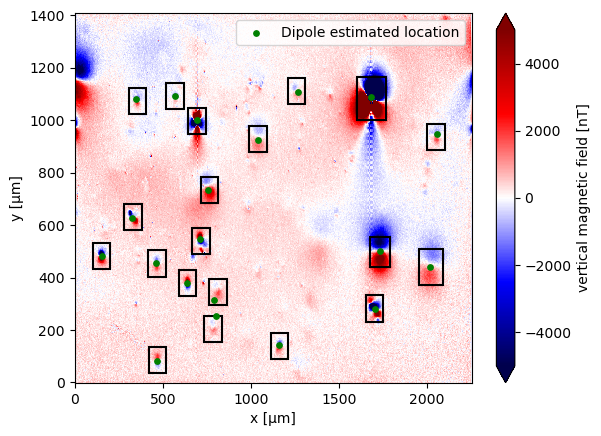

In [2]:
import numpy as np
import magali as mg
import harmonica as hm
import skimage.exposure
import xarray as xr
import matplotlib.pyplot as plt
import ensaio

fname = ensaio.fetch_morroco_speleothem_qdm(version=1, file_format="matlab")
data = mg.read_qdm_harvard(fname)

height_difference = 5.0

data_up = (
    hm.upward_continuation(data, height_difference)
    .assign_attrs(data.attrs)
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
    .rename("bz")
)

dx, dy, dz, tga = mg.gradient(data_up)
data_up["dx"], data_up["dy"], data_up["dz"], data_up["tga"] = dx, dy, dz, tga

stretched = skimage.exposure.rescale_intensity(
    tga, in_range=tuple(np.percentile(tga, (1, 99)))
)
data_tga_stretched = xr.DataArray(stretched, coords=data_up.coords)

bounding_boxes = mg.detect_anomalies(
    data_tga_stretched,
    size_range=[30, 50],
    detection_threshold=0.07,
    border_exclusion=2,
)

data_updated, locations_, dipole_moments_, r2_values = mg.iterative_nonlinear_inversion(
    data_up,
    bounding_boxes,
    height_difference=height_difference,
    copy_data=True,
)

fig, ax = plt.subplots()
data.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-5000, vmax=5000)
mg.plot_bounding_boxes(bounding_boxes, ax=ax, color="black", linewidth=1.5)
locations_arr = np.array(locations_)
ax.scatter(
    locations_arr[:, 0],  # x
    locations_arr[:, 1],  # y
    c="green",
    marker=".",
    s=60,
    label="Dipole estimated location"
)
plt.legend()
plt.savefig("assets/magali_code_example.png", dpi=1000)
plt.show()
